In [1]:
import math

import torch
import torch.nn as nn
import torchvision


def weights_init(m):
    # Initialize filters with Gaussian random weights
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()


class MeanFieldUpdate(nn.Module):
    """
    Meanfield updating for the features and the attention for one pair of features.
    bottom_list is a list of observation features derived from the backbone CNN.
    update attention map
    a_s <-- y_s * (K_s conv y_S)
    a_s = b_s conv a_s
    a_s <-- Sigmoid(-(a_s + a_s))
    update the last scale feature map y_S
    y_s <-- K conv y_s
    y_S <-- x_S + (a_s * y_s)
    """

    def __init__(self, bottom_send, bottom_receive, feat_num):
        super(MeanFieldUpdate, self).__init__()

        self.atten_f = nn.Conv2d(in_channels=bottom_send + bottom_receive, out_channels=feat_num,
                                 kernel_size=3, stride=1, padding=1)
        self.norm_atten_f = nn.Sigmoid()
        self.message_f = nn.Conv2d(in_channels=bottom_send, out_channels=feat_num, kernel_size=3,
                                   stride=1, padding=1)
        self.Scale = nn.Conv2d(in_channels=feat_num, out_channels=bottom_receive, kernel_size=1, bias=True)

    def forward(self, x_s, x_S):
        # update attention map
        a_s = torch.cat((x_s, x_S), dim=1)
        a_s = self.atten_f(a_s)
        a_s = self.norm_atten_f(a_s)

        # update the last scale feature map y_S
        y_s = self.message_f(x_s)
        y_S = y_s.mul(a_s)  # production
        # scale
        y_S = self.Scale(y_S)
        y_S = x_S + y_S  # eltwise sum
        return y_S


class SAN(nn.Module):
    """
    Based on ResNet-50
    """

    def __init__(self, in_channels=3, feat_num=512, feat_width=80, feat_height=24, pretrained=True):
        super(SAN, self).__init__()

        # backbone Net: ResNet
        pretrained_model = torchvision.models.__dict__['resnet{}'.format(50)](pretrained=pretrained)
        self.channel = in_channels

        self.conv1 = pretrained_model._modules['conv1']
        self.bn1 = pretrained_model._modules['bn1']
        self.relu = pretrained_model._modules['relu']

        self.maxpool = pretrained_model._modules['maxpool']
        self.layer1 = pretrained_model._modules['layer1']
        self.layer2 = pretrained_model._modules['layer2']
        self.layer3 = pretrained_model._modules['layer3']
        self.layer4 = pretrained_model._modules['layer4']

        # generating multi-scale features with the same dimension
        # in paper,  type = 'gaussian'
        self.res4f_dec_1 = nn.ConvTranspose2d(1024, feat_num, kernel_size=4, stride=2, padding=1)
        
        self.res4f_dec_1_relu = nn.ReLU(inplace=True)

        # in paper,  type = 'gaussian'
        self.res5c_dec_1 = nn.ConvTranspose2d(2048, feat_num, kernel_size=8, stride=4, padding=2)
        self.res5c_dec_1_relu = nn.ReLU(inplace=True)

        self.res4f_dec = nn.UpsamplingBilinear2d(size=(feat_height, feat_width))
        self.res3d_dec = nn.UpsamplingBilinear2d(size=(feat_height, feat_width))
        self.res5c_dec = nn.UpsamplingBilinear2d(size=(feat_height, feat_width))

        # add deep supervision for three semantic layers
        self.prediction_3d = nn.Conv2d(feat_num, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.prediction_4f = nn.Conv2d(feat_num, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.prediction_5c = nn.Conv2d(feat_num, out_channels=1, kernel_size=3, stride=1, padding=1)

        # the first meanfield updating
        self.meanFieldUpdate1_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate1_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate1_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # the second meanfield updating
        self.meanFieldUpdate2_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate2_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate2_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # the third meanfield updating
        self.meanFieldUpdate3_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate3_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate3_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # the fourth meanfield updating
        self.meanFieldUpdate4_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate4_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate4_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # the fifth meanfield updating
        self.meanFieldUpdate5_1 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate5_2 = MeanFieldUpdate(feat_num, feat_num, feat_num)
        self.meanFieldUpdate5_3 = MeanFieldUpdate(feat_num, feat_num, feat_num)

        # produce the output
        self.pred_1 = nn.ConvTranspose2d(feat_num, feat_num // 2, kernel_size=4, stride=2, padding=1)
        self.pred_1_relu = nn.ReLU(inplace=True)
        self.pred_2 = nn.ConvTranspose2d(feat_num // 2, feat_num // 4, kernel_size=4, stride=2, padding=1)
        self.pred_2_relu = nn.ReLU(inplace=True)
        self.pred_3 = nn.Conv2d(feat_num // 4, 1, kernel_size=3, stride=1, padding=1)

        # weights init
        self.res4f_dec_1.apply(weights_init)
        self.res5c_dec_1.apply(weights_init)
        self.prediction_3d.apply(weights_init)
        self.prediction_4f.apply(weights_init)
        self.prediction_5c.apply(weights_init)

        self.meanFieldUpdate1_1.apply(weights_init)
        self.meanFieldUpdate1_2.apply(weights_init)
        self.meanFieldUpdate1_3.apply(weights_init)

        self.meanFieldUpdate2_1.apply(weights_init)
        self.meanFieldUpdate2_2.apply(weights_init)
        self.meanFieldUpdate2_3.apply(weights_init)

        self.meanFieldUpdate3_1.apply(weights_init)
        self.meanFieldUpdate3_2.apply(weights_init)
        self.meanFieldUpdate3_3.apply(weights_init)

        self.meanFieldUpdate4_1.apply(weights_init)
        self.meanFieldUpdate4_2.apply(weights_init)
        self.meanFieldUpdate4_3.apply(weights_init)

        self.meanFieldUpdate5_1.apply(weights_init)
        self.meanFieldUpdate5_2.apply(weights_init)
        self.meanFieldUpdate5_3.apply(weights_init)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        res3d = x
        x = self.layer3(x)
        res4f = x
        x = self.layer4(x)
        res5c = x

        # generate multi-scale features with the same dimension,
        res4f_1 = self.res4f_dec_1(res4f)  # 1024 --> 512
        res4f_1 = self.res4f_dec_1_relu(res4f_1)

        res5c_1 = self.res5c_dec_1(res5c)  # 1024 --> 512
        res4f_1 = self.res5c_dec_1_relu(res5c_1)

        res4f = self.res4f_dec(res4f_1)
        res3d = self.res3d_dec(res3d)
        res5c = self.res5c_dec(res5c_1)

        pred_3d = self.prediction_3d(res3d)
        pred_4f = self.prediction_4f(res4f)
        pred_5c = self.prediction_5c(res5c)

        # five meanfield updating
        y_S = self.meanFieldUpdate1_1(res3d, res5c)
        y_S = self.meanFieldUpdate1_2(res4f, y_S)
        y_S = self.meanFieldUpdate1_3(res5c, y_S)

        y_S = self.meanFieldUpdate2_1(res3d, y_S)
        y_S = self.meanFieldUpdate2_2(res4f, y_S)
        y_S = self.meanFieldUpdate2_3(res5c, y_S)

        y_S = self.meanFieldUpdate3_1(res3d, y_S)
        y_S = self.meanFieldUpdate3_2(res4f, y_S)
        y_S = self.meanFieldUpdate3_3(res5c, y_S)

        y_S = self.meanFieldUpdate4_1(res3d, y_S)
        y_S = self.meanFieldUpdate4_2(res4f, y_S)
        y_S = self.meanFieldUpdate4_3(res5c, y_S)

        y_S = self.meanFieldUpdate5_1(res3d, y_S)
        y_S = self.meanFieldUpdate5_2(res4f, y_S)
        y_S = self.meanFieldUpdate5_3(res5c, y_S)

        pred = self.pred_1(y_S)
        pred = self.pred_1_relu(pred)
        pred = self.pred_2(pred)
        pred = self.pred_2_relu(pred)
        pred = self.pred_3(pred)

        # UpSample to output size
        pred_3d = nn.functional.interpolate(pred_3d, size=(188, 621), mode='bilinear', align_corners=True)
        pred_4f = nn.functional.interpolate(pred_4f, size=(188, 621), mode='bilinear', align_corners=True)
        pred_5c = nn.functional.interpolate(pred_5c, size=(188, 621), mode='bilinear', align_corners=True)
        pred = nn.functional.interpolate(pred, size=(188, 621), mode='bilinear', align_corners=True)

        return pred_3d, pred_4f, pred_5c, pred

if __name__ == "__main__":
    model = SAN(feat_width=80, feat_height=24)
    model = model.cuda()
    model.eval()
    from matplotlib.image import imread

    img = imread('C:/Users/Ant Pc/DepthEstimation/test.jpg')
    img=img[250:250+80,0:24,:].reshape(1,3,80,24)
    img=torch.from_numpy(img).float()
    image = img.cuda()

    with torch.no_grad():
        pred_3d, pred_4f, pred_5c, pred = model(image)

    print(pred_3d.size())
    print(pred_4f.size())
    print(pred_5c.size())
    print(pred.size())

torch.Size([1, 3, 80, 24])
torch.Size([1, 1, 188, 621])
torch.Size([1, 1, 188, 621])
torch.Size([1, 1, 188, 621])
torch.Size([1, 1, 188, 621])


In [2]:
pred_3d[0,0,120-40:120+40,500]

tensor([-548.4257, -551.1540, -552.4523, -553.1249, -553.7976, -554.4703,
        -555.1430, -555.8157, -556.4883, -557.1610, -555.7488, -552.7330,
        -549.7171, -546.7012, -543.6853, -540.6694, -537.6535, -534.6376,
        -534.6821, -538.7050, -542.7280, -546.7509, -550.7739, -554.7969,
        -558.8198, -562.8427, -566.3995, -568.8906, -571.3817, -573.8729,
        -576.3640, -578.8552, -581.3463, -583.8374, -584.7050, -577.8606,
        -571.0162, -564.1719, -557.3275, -550.4831, -543.6387, -536.7944,
        -530.2112, -529.3768, -528.5422, -527.7077, -526.8732, -526.0386,
        -525.2041, -524.3696, -523.5350, -520.1281, -516.4762, -512.8242,
        -509.1723, -505.5204, -501.8685, -498.2166, -494.5646, -492.8371,
        -491.6440, -490.4509, -489.2579, -488.0648, -486.8718, -485.6787,
        -484.4857, -482.7725, -480.7820, -478.7914, -476.8008, -474.8102,
        -472.8197, -470.8291, -468.8385, -469.1461, -471.5603, -473.9745,
        -476.3886, -478.8028], device=

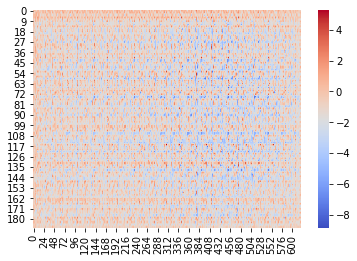

In [7]:
import seaborn as sns
sns.heatmap(pred.detach().cpu().numpy().reshape(188,621),cmap='coolwarm')

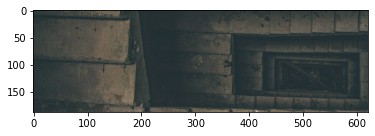

In [8]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

img = imread('C:/Users/Ant Pc/DepthEstimation/test.jpg')

img=img[250:250+188,0:621,:].reshape(188,621,3)
plt.imshow(img)

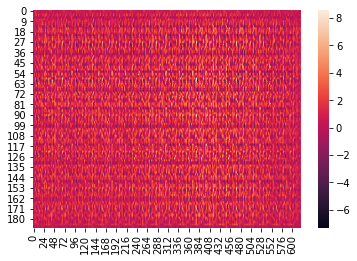

In [55]:
import seaborn as sns
sns.heatmap(pred.detach().cpu().numpy().reshape(188,621))

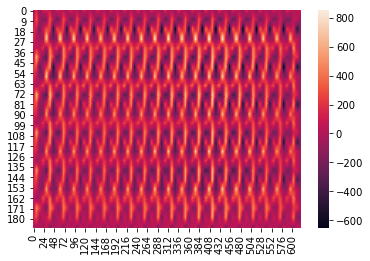

In [57]:
import seaborn as sns
sns.heatmap(pred_4f.detach().cpu().numpy().reshape(188,621))

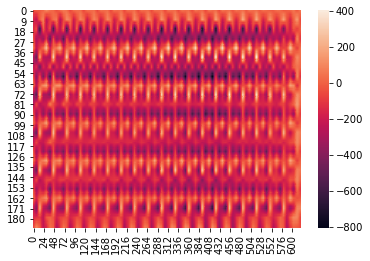

In [58]:
import seaborn as sns
sns.heatmap(pred_5c.detach().cpu().numpy().reshape(188,621))

In [3]:
import torch
a = torch.randn(3)
print(torch.mul(a, 100),a)

tensor([  86.0503,   71.2715, -209.6976]) tensor([ 0.8605,  0.7127, -2.0970])


In [4]:
a.mul(100)

tensor([  86.0503,   71.2715, -209.6976])